In [1]:
%cd ..

/nfs/scistore16/edelgrp/fzimin/depth-poset


/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt

from tqdm import tqdm

import matplotlib.pyplot as plt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/ipykern

AttributeError: _ARRAY_API not found

# Utils

In [3]:
def load_text(path):
    # read the file
    with open(path, 'r') as file:
        text = file.read()
    return text

In [4]:
def get_line_starts_with(s, start):
    s = s.split('\n')
    for line in s:
        if line.find(start) == 0:
            return line

## Exclude info functions

In [5]:
def get_task_id(log):
    #
    for s in log.split('\n'):
        if s.find('SLURM_ARRAY_TASK_ID =') == 0:
            return int(s.replace('SLURM_ARRAY_TASK_ID =', '').replace("'", "").strip())

In [6]:
def get_error_line(log):
    # returns an error line if exists
    for s in log.split('\n'):
        if s.lower().find('error') != -1:
            return s

In [7]:
def get_dim(log):
    for s in log.split('\n'):
        if s.find('dim=') == 0:
            return s[4:]

In [8]:
def get_n(log):
    for s in log.split('\n'):
        if s.find('n=') == 0:
            return s[2:]

In [9]:
def get_error(line):
    if line is None:
        return 'no errors'
    if line.find('FileNotFoundError') != -1:
        return 'FileNotFoundError'
    if line.find('out-of-memory') != -1:
        return 'out-of-memory'
    if line.find('the following arguments are required') != -1:
        return "input-error"
    if line.find('DUE TO TIME LIMIT') != -1:
        return 'time-limit'
    if line.find('CANCELLED') != -1:
        return 'canceled'
    if line.find('slurmstepd') != -1:
        return 'slurm-error'
    return line

In [10]:
def process_is_done(log):
    return log.find('The result is saved to path') != -1

In [11]:
def get_process_status(row):
    if (row['error_line'] is None) and (not row['done']):
        return 'processing'
    if row['done']:
        err = row['error']
        return f'done with {err}'
    return row['error']

In [12]:
def get_times_series(log: str) -> pd.Series:
    # 
    lines = np.array(log.split('\n'))
    lines = lines[np.char.find(lines, 'seconds') != -1]
    time_vals = np.array([line.split(' ')[-2] for line in lines]).astype(float)
    info_vals = np.array([' '.join(line.split(' ')[:-3]) for line in lines], dtype=str)
    info_vals[np.char.find(info_vals, 'Generated') == 0] = 'Complex generation'
    return pd.Series(time_vals, index=info_vals)

In [13]:
def get_digits_from_string(string):
    # 
    return int(''.join([char for char in string if char.isdigit()]))

# Depth Poset Scores

## Logs

In [14]:
# path to log-files
path_logs_scores = 'logs/scores_on_extended_cubical_torus'

# define path for each log-file
df_logs_scores = pd.DataFrame({'log-path': os.listdir(path_logs_scores)})
df_logs_scores['log-path'] = df_logs_scores['log-path'].apply(lambda s: os.path.join(path_logs_scores, s))
df_logs_scores = df_logs_scores[df_logs_scores['log-path'].apply(lambda s: Path(s).suffix) == '.log']

# define job index
df_logs_scores['job'] = df_logs_scores['log-path'].apply(lambda s: s[36:-4])

# load logs
df_logs_scores['log'] = df_logs_scores['log-path'].apply(load_text)

# define task id
df_logs_scores['task-id'] = df_logs_scores['log'].apply(get_task_id)


# get params from log
df_logs_scores['dim'] = df_logs_scores['log'].apply(get_dim)
df_logs_scores['n'] = df_logs_scores['log'].apply(get_n)

df_logs_scores['error_line'] = df_logs_scores['log'].apply(get_error_line)
df_logs_scores['error'] = df_logs_scores['error_line'].apply(get_error)

df_logs_scores['done'] = df_logs_scores['log'].apply(process_is_done)
df_logs_scores['status'] = df_logs_scores.apply(get_process_status, axis=1)


df_logs_scores = pd.concat([df_logs_scores, df_logs_scores['log'].apply(get_times_series).sort_index(axis=1)], axis=1)


print(f'df_logs_scores.shape = {df_logs_scores.shape}')
df_logs_scores.head()

df_logs_scores.shape = (752, 79)


,log-path,job,log,task-id,dim,n,error_line,error,done,status,...,Poset scores 6/39: Calculated the score number_of_nodes for the object full,Poset scores 6/8: Calculated the score height for the object subposet dim=0,Poset scores 7/16: Calculated the score number_of_nodes for the object subposet dim=0,Poset scores 7/39: Calculated the score number_of_relations for the object full,Poset scores 7/8: Calculated the score number_of_nodes for the object subposet dim=0,Poset scores 8/16: Calculated the score number_of_relations for the object subposet dim=0,Poset scores 8/39: Calculated the score cycles_dimension for the object subposet dim=0,Poset scores 8/8: Calculated the score number_of_relations for the object subposet dim=0,Poset scores 9/16: Calculated the score cycles_dimension for the object subposet dim=1,Poset scores 9/39: Calculated the score height for the object subposet dim=0
0,logs/scores_on_extended_cubical_torus/output_4...,s/output_45485165,SLURM_ARRAY_TASK_ID = '141'\nPARAMS:\ndim=1\nn...,141,1,56,None,no errors,True,done with no errors,...,NaN,0.0015,NaN,NaN,0.0,NaN,NaN,0.0011,NaN,NaN
1,logs/scores_on_extended_cubical_torus/output_4...,s/output_45484344,SLURM_ARRAY_TASK_ID = '26'\nPARAMS:\ndim=1\nn=...,26,1,14,None,no errors,True,done with no errors,...,NaN,0.0003,NaN,NaN,0.0,NaN,NaN,0.0002,NaN,NaN
2,logs/scores_on_extended_cubical_torus/output_4...,s/output_45489215,SLURM_ARRAY_TASK_ID = '386'\nPARAMS:\ndim=2\nn...,386,2,48,None,no errors,True,done with no errors,...,0.0,NaN,NaN,0.1363,NaN,NaN,0.0515,NaN,NaN,0.0415
3,logs/scores_on_extended_cubical_torus/output_4...,s/output_45484395,SLURM_ARRAY_TASK_ID = '77'\nPARAMS:\ndim=1\nn=...,77,1,28,None,no errors,True,done with no errors,...,NaN,0.0018,NaN,NaN,0.0,NaN,NaN,0.0014,NaN,NaN
4,logs/scores_on_extended_cubical_torus/output_4...,s/output_45490681,SLURM_ARRAY_TASK_ID = '533'\nPARAMS:\ndim=3\nn...,533,3,16,slurmstepd-eta357: error: Detected 1 oom-kill ...,out-of-memory,False,out-of-memory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_score_status = df_logs_scores[['dim', 'n', 'status']].value_counts()
df_score_status = df_score_status.reset_index()
df_score_status = df_score_status.pivot_table(columns=['dim', 'status'], index='n', values='count')
df_score_status = df_score_status.fillna(0).astype('Int32')

def sort_key(index):
    index = index.strip()
    return (0, 0) if index == '' else (1, int(index))
df_score_status = df_score_status.loc[sorted(df_score_status.index, key=sort_key)]

df_score_status

dim                                  1                   2  \
status input-error done with no errors done with no errors   
n                                                            
                 2                   0                   0   
3                0                  10                  10   
4                0                  10                  10   
5                0                  10                  10   
6                0                  10                  10   
7                0                  10                  10   
8                0                  10                  10   
9                0                  10                  10   
10               0                  10                  10   
11               0                  10                  10   
12               0                  10                  10   
13               0                  10                  10   
14               0                  10                  10   
15               0                  10                  10   
16               0                  10                  10   
20               0                  10                  10   
24               0                  10                  10   
28               0                  10                   5   
32               0                  10                  10   
36               0                  10                  10   
40               0                  10                  10   
44               0                  10                  10   
48               0                  10                  10   
52               0                  10                  10   
56               0                  10                  10   
60               0                  10                  10   
64               0                  10                  10   
68               0                  10                  10   
72               0                  10                  10   
76               0                  10                  10   
80               0                  10                  10   
84               0                  10                   0   
88               0                  10                   0   
92               0                  10                   0   
96               0                  10                   0   
100              0                  10                   0   

dim                                            3                           
status done with slurm-error done with no errors out-of-memory time-limit  
n                                                                          
                           0                   0             0          0  
3                          0                  10             0          0  
4                          0                  10             0          0  
5                          0                  10             0          0  
6                          0                  10             0          0  
7                          0                   0             0          0  
8                          0                  10             0          0  
9                          0                   0             0          0  
10                         0                   0             0          0  
11                         0                   0             0          0  
12                         0                  10             0          0  
13                         0                  10             0          0  
14                         0                   8             0          2  
15                         0                   0             0         10  
16                         0                   0            10          0  
20                         0                   0             0          0  
24                         0                   0             0          0  
28                         5                   0             

In [16]:
df_logs_scores[df_logs_scores['status'] == 'processing'].groupby(['dim', 'n'])['job'].count().reset_index()

,dim,n,job


In [17]:
df_logs_scores

,log-path,job,log,task-id,dim,n,error_line,error,done,status,...,Poset scores 6/39: Calculated the score number_of_nodes for the object full,Poset scores 6/8: Calculated the score height for the object subposet dim=0,Poset scores 7/16: Calculated the score number_of_nodes for the object subposet dim=0,Poset scores 7/39: Calculated the score number_of_relations for the object full,Poset scores 7/8: Calculated the score number_of_nodes for the object subposet dim=0,Poset scores 8/16: Calculated the score number_of_relations for the object subposet dim=0,Poset scores 8/39: Calculated the score cycles_dimension for the object subposet dim=0,Poset scores 8/8: Calculated the score number_of_relations for the object subposet dim=0,Poset scores 9/16: Calculated the score cycles_dimension for the object subposet dim=1,Poset scores 9/39: Calculated the score height for the object subposet dim=0
0,logs/scores_on_extended_cubical_torus/output_4...,s/output_45485165,SLURM_ARRAY_TASK_ID = '141'\nPARAMS:\ndim=1\nn...,141,1,56,None,no errors,True,done with no errors,...,NaN,0.0015,NaN,NaN,0.0,NaN,NaN,0.0011,NaN,NaN
1,logs/scores_on_extended_cubical_torus/output_4...,s/output_45484344,SLURM_ARRAY_TASK_ID = '26'\nPARAMS:\ndim=1\nn=...,26,1,14,None,no errors,True,done with no errors,...,NaN,0.0003,NaN,NaN,0.0,NaN,NaN,0.0002,NaN,NaN
2,logs/scores_on_extended_cubical_torus/output_4...,s/output_45489215,SLURM_ARRAY_TASK_ID = '386'\nPARAMS:\ndim=2\nn...,386,2,48,None,no errors,True,done with no errors,...,0.0,NaN,NaN,0.1363,NaN,NaN,0.0515,NaN,NaN,0.0415
3,logs/scores_on_extended_cubical_torus/output_4...,s/output_45484395,SLURM_ARRAY_TASK_ID = '77'\nPARAMS:\ndim=1\nn=...,77,1,28,None,no errors,True,done with no errors,...,NaN,0.0018,NaN,NaN,0.0,NaN,NaN,0.0014,NaN,NaN
4,logs/scores_on_extended_cubical_torus/output_4...,s/output_45490681,SLURM_ARRAY_TASK_ID = '533'\nPARAMS:\ndim=3\nn...,533,3,16,slurmstepd-eta357: error: Detected 1 oom-kill ...,out-of-memory,False,out-of-memory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,logs/scores_on_extended_cubical_torus/output_4...,s/output_45486737,SLURM_ARRAY_TASK_ID = '163'\nPARAMS:\ndim=1\nn...,163,1,64,None,no errors,True,done with no errors,...,NaN,0.0010,NaN,NaN,0.0,NaN,NaN,0.0008,NaN,NaN
748,logs/scores_on_extended_cubical_torus/output_4...,s/output_45485154,SLURM_ARRAY_TASK_ID = '130'\nPARAMS:\ndim=1\nn...,130,1,48,None,no errors,True,done with no errors,...,NaN,0.0011,NaN,NaN,0.0,NaN,NaN,0.0009,NaN,NaN
749,logs/scores_on_extended_cubical_torus/output_4...,s/output_45484375,SLURM_ARRAY_TASK_ID = '57'\nPARAMS:\ndim=1\nn=...,57,1,20,None,no errors,True,done with no errors,...,NaN,0.0004,NaN,NaN,0.0,NaN,NaN,0.0003,NaN,NaN
750,logs/scores_on_extended_cubical_torus/output_4...,s/output_45490661,SLURM_ARRAY_TASK_ID = '513'\nPARAMS:\ndim=3\nn...,513,3,14,None,no errors,True,done with no errors,...,NaN,NaN,0.0,NaN,NaN,0.1153,NaN,NaN,1.346,NaN


In [18]:
log = df_logs_scores['log'].iloc[100]
log = df_logs_scores[(df_logs_scores['dim'] == '3')&(df_logs_scores['n'] == '15')]['log'].iloc[0]

print(log)

SLURM_ARRAY_TASK_ID = '526'
PARAMS:
dim=3
n=15
Calculate the scores for the barycentric model on the 3-dimensional torus with sides splited to 15 cells.
Generated the 3-dimensional torus of shape-(15, 15, 15) with random barycentric filtration in 0.0007 seconds.
slurmstepd-eta357: error: *** JOB 45490674 ON eta357 CANCELLED AT 2025-07-18T17:00:18 DUE TO TIME LIMIT ***



In [19]:
log = df_logs_scores['log'].iloc[100]
log = df_logs_scores[(df_logs_scores['dim'] == '3')&(df_logs_scores['n'] == '16')]['log'].iloc[0]

print(log)

SLURM_ARRAY_TASK_ID = '533'
PARAMS:
dim=3
n=16
Calculate the scores for the barycentric model on the 3-dimensional torus with sides splited to 16 cells.
Generated the 3-dimensional torus of shape-(16, 16, 16) with random barycentric filtration in 0.0007 seconds.
/var/lib/slurm/slurmd/job45490681/slurm_script: line 23: 2656120 Killed                  python -u scripts/calculate_scores_on_extended_cubical_torus.py $dim $n
slurmstepd-eta357: error: Detected 1 oom-kill event(s) in StepId=45490681.batch. Some of your processes may have been killed by the cgroup out-of-memory handler.



# Transpositions

# utils

In [20]:
def get_path(log, key='path'):
    # 
    for s in log.split('\n'):
        if (s.find(key) == 0) and (s.find('=') != -1):
            return s[s.find('=') + 1:]

In [21]:
def get_dim_and_n(path):
    try:
        with open(path, "rb") as file:
            data = pkl.load(file)
        n = data['n']
        dim = data['dim']
        return dim, n
    except FileNotFoundError:
        return None

## log

In [22]:
# path to log-files
path_logs_transp = 'logs/transpositions_during_homotopies_between_extended_cubical_toruses'

# define path for each log-file
df_logs_transp = pd.DataFrame({'log-path': os.listdir(path_logs_transp)})
df_logs_transp['log-path'] = df_logs_transp['log-path'].apply(lambda s: os.path.join(path_logs_transp, s))
df_logs_transp = df_logs_transp[df_logs_transp['log-path'].apply(lambda s: Path(s).suffix) == '.log']

# load logs
tqdm.pandas()
df_logs_transp['log'] = df_logs_transp['log-path'].progress_apply(load_text)

# define task id
assert df_logs_transp['log'].apply(lambda s: s.find('SLURM_ARRAY_TASK_ID') == 0).all()
df_logs_transp['task-id'] = df_logs_transp['log'].apply(lambda s: s.split('\n')[0]).apply(lambda s: s[s.find("'") + 1:s.rfind("'")]).astype(int)

# job
df_logs_transp['job'] = df_logs_transp['log-path'].apply(get_digits_from_string)
df_logs_transp['job'] = df_logs_transp['job'].astype(int) - df_logs_transp['task-id'].astype(int) - 1 # there is a gap in some moment


df_logs_transp = df_logs_transp.sort_values(['job', 'task-id']).reset_index(drop=True)

# paths
df_logs_transp['path0'] = df_logs_transp['log'].apply(lambda log: get_path(log, key='path0'))
df_logs_transp['path1'] = df_logs_transp['log'].apply(lambda log: get_path(log, key='path1'))

# define dim and n
df_path_ndim = df_logs_transp[['path0']].drop_duplicates()

df_path_ndim['dimn0'] = df_path_ndim['path0'].progress_apply(get_dim_and_n)
df_path_ndim['dim'] = df_path_ndim['dimn0'].apply(lambda dimn: None if dimn is None else dimn[0]).astype('Int32')
df_path_ndim['n'] = df_path_ndim['dimn0'].apply(lambda dimn: None if dimn is None else dimn[1]).astype('Int32')
df_path_ndim = df_path_ndim.set_index('path0')
df_logs_transp['dim'] = df_logs_transp['path0'].map(df_path_ndim['dim'])
df_logs_transp['n'] = df_logs_transp['path0'].map(df_path_ndim['n'])


# define error and status
df_logs_transp['error_line'] = df_logs_transp['log'].progress_apply(get_error_line)
df_logs_transp['error'] = df_logs_transp['error_line'].apply(get_error)
df_logs_transp['done'] = df_logs_transp['log'].apply(process_is_done)
df_logs_transp['status'] = df_logs_transp.apply(get_process_status, axis=1)

print(f'df_logs_transp.shape = {df_logs_transp.shape}')
df_logs_transp.head()

100%|██████████| 4766/4766 [00:04<00:00, 1144.10it/s] 


df_logs_transp.shape = (4766, 12)


,log-path,log,task-id,job,path0,path1,dim,n,error_line,error,done,status
0,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '1349'\nLINE: ""results/s...",1349,46104805,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,80,slurmstepd-zeta252: error: Detected 1 oom-kill...,out-of-memory,False,out-of-memory
1,logs/transpositions_during_homotopies_between_...,SLURM_ARRAY_TASK_ID = '0'\nsed: -e expression ...,0,46106178,,,<NA>,<NA>,FileNotFoundError: [Errno 2] No such file or d...,FileNotFoundError,False,FileNotFoundError
2,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '1'\nLINE: ""results/scor...",1,46106178,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,3,None,no errors,True,done with no errors
3,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '2'\nLINE: ""results/scor...",2,46106178,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,3,None,no errors,True,done with no errors
4,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '3'\nLINE: ""results/scor...",3,46106178,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,3,None,no errors,True,done with no errors


In [33]:
jobs = df_logs_transp[df_logs_transp['status'] == 'processing']['job'].values

df_transp_status = df_logs_transp[df_logs_transp['job'].isin(jobs)]
#df_transp_status = df_logs_transp
df_transp_status = df_transp_status[['dim', 'n', 'status']].value_counts(dropna=False).reset_index()
df_transp_status = df_transp_status.pivot_table(columns=['dim', 'status'], index='n', values='count', dropna=False)
df_transp_status = df_transp_status.fillna(0).astype(int)

df_transp_status = df_transp_status[df_transp_status.columns[(df_transp_status != 0).any()]]
df_transp_status

dim           2                         
status canceled out-of-memory processing
n                                       
12            1             0          1
13            0             0         45
14            0             0         45
15           45             0         39
16           45             0         45
20           33             0         57
24           45             0         45
28           45             0         45
32           45             0         45
36           45             0         45
40           45             0         45
44           45             0          0
48           45             0          0
52           45             0          0
56           45             0          0
60           45             0          0
64           45             0          0
68           45             0          0
72           45             0          0
76            0            45          0
80            0            44          0

## Processing tasks

In [24]:
def get_last_line_or_portion(log):
    # returns the last line in the log and extract the portion, if it's given there
    s = np.array(log.split('\n'))
    s = s[s != '']
    s = s[-1]
    
    if s.find('-') == -1:
        return s
    s = s[:s.find('-')].strip()
    try:
        i0, i1 = s.split('/') 
        i0 = int(i0)
        i1 = int(i1)
        return i0/i1
    except Exception as err:
        return s

indices = ['job', 'task-id']
df_processing = df_logs_transp.set_index(indices)
df_processing = df_processing[df_processing['status'] == 'processing']

df_processing['log'].apply(get_last_line_or_portion)#.reset_index()

job       task-id
46315314  2            self._set_arrayXarray_sparse(i, j, x)
          3            self._set_arrayXarray_sparse(i, j, x)
          4            self._set_arrayXarray_sparse(i, j, x)
          5            self._set_arrayXarray_sparse(i, j, x)
          6            self._set_arrayXarray_sparse(i, j, x)
                                      ...                   
46324962  355                         cross_parameters = (t1
          356                         cross_parameters = (t1
          357                         cross_parameters = (t1
          358                         cross_parameters = (t1
          359                         cross_parameters = (t1
Name: log, Length: 457, dtype: object

In [25]:
if len(df_processing) == 0:
    print('There is no any processing task.')
else:
    log = df_logs_transp[df_logs_transp['status'] == 'processing']['log'].iloc[0]

    n0, n1 = 36, 12
    if len(log.split('\n')) <= n0 + n1:
        print(log)
    else:
        print('\n'.join(log.split('\n')[:n0] + log.split('\n')[-n1:]))

SLURM_ARRAY_TASK_ID = '2'
LINE: "results/scores-on-barycentric-cubical-toruses-extended/2025-07-15 16:32:36.839757.pkl" "results/scores-on-barycentric-cubical-toruses-extended/2025-07-15 16:32:38.248590.pkl"
PARAMS:
path0=results/scores-on-barycentric-cubical-toruses-extended/2025-07-15 16:32:36.839757.pkl
path1=results/scores-on-barycentric-cubical-toruses-extended/2025-07-15 16:32:38.248590.pkl
DATETIME:
Wed Jul 23 09:57:42 PM CEST 2025
/nfs/scistore16/edelgrp/fzimin/depth-poset/src/utils.py:135: RuntimeWarning: divide by zero encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0
/nfs/scistore16/edelgrp/fzimin/depth-poset/src/utils.py:135: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0
/nfs/scistore16/edelgrp/fzimin/depth-poset/venv/lib/python3.11/site-packages/scipy/sparse/_index.py:201: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expen

## Repeated tasks

In [26]:
df_logs_repeats = df_logs_transp[df_logs_transp['status'].isin(['done with no errors', 'processing'])]
df_logs_repeats = df_logs_repeats[df_logs_repeats[['path0', 'path1']].duplicated(keep=False)]
df_logs_repeats

,log-path,log,task-id,job,path0,path1,dim,n,error_line,error,done,status
3698,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '188'\nLINE: ""results/sc...",188,46315315,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,20,None,no errors,False,processing
3699,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '189'\nLINE: ""results/sc...",189,46315315,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,20,None,no errors,False,processing
3700,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '190'\nLINE: ""results/sc...",190,46315315,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,20,None,no errors,False,processing
3701,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '191'\nLINE: ""results/sc...",191,46315315,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,20,None,no errors,False,processing
3702,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '192'\nLINE: ""results/sc...",192,46315315,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,20,None,no errors,False,processing
3703,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '193'\nLINE: ""results/sc...",193,46315315,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,20,None,no errors,False,processing
3704,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '194'\nLINE: ""results/sc...",194,46315315,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,20,None,no errors,False,processing
3705,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '195'\nLINE: ""results/sc...",195,46315315,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,20,None,no errors,False,processing
3706,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '196'\nLINE: ""results/sc...",196,46315315,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,20,None,no errors,False,processing
3707,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '197'\nLINE: ""results/sc...",197,46315315,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,20,None,no errors,False,processing


## Done tasks

In [27]:
def get_total_time(log):
    # 
    scores_time = 0
    for line in log.split('\n'):
        if line.find('So the total duration of seeking transpositions ') == 0:
            transp_time =  float(line.split(' ')[-2])
        if line.find('So all scores for ') == 0:
            scores_time =  float(line.split(' ')[-2])
            
    return transp_time + scores_time

In [28]:
df_done_transp = df_logs_transp[df_logs_transp['status'] == 'done with no errors']

df_done_transp['time'] = df_done_transp['log'].progress_apply(get_total_time)

df_done_transp.head()

100%|██████████| 449/449 [00:04<00:00, 93.88it/s]  
/tmp/ipykernel_685995/1247347440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_done_transp['time'] = df_done_transp['log'].progress_apply(get_total_time)


,log-path,log,task-id,job,path0,path1,dim,n,error_line,error,done,status,time
2,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '1'\nLINE: ""results/scor...",1,46106178,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,3,None,no errors,True,done with no errors,1.1118
3,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '2'\nLINE: ""results/scor...",2,46106178,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,3,None,no errors,True,done with no errors,1.0420
4,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '3'\nLINE: ""results/scor...",3,46106178,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,3,None,no errors,True,done with no errors,1.1352
5,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '4'\nLINE: ""results/scor...",4,46106178,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,3,None,no errors,True,done with no errors,1.0259
6,logs/transpositions_during_homotopies_between_...,"SLURM_ARRAY_TASK_ID = '5'\nLINE: ""results/scor...",5,46106178,results/scores-on-barycentric-cubical-toruses-...,results/scores-on-barycentric-cubical-toruses-...,2,3,None,no errors,True,done with no errors,1.0959


In [29]:
def format_seconds_to_hhmmss(sec):
    total_seconds = int(sec)
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    return f"{hours:02}:{minutes:02}:{seconds:02}"

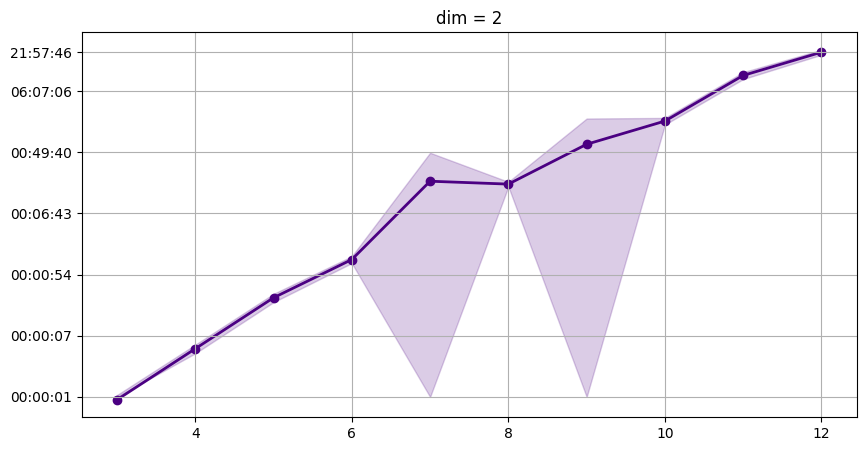

In [30]:
df_done_time_mean = df_done_transp.groupby(['dim', 'n'])['time'].mean().reset_index().pivot_table(index='n', columns='dim', values='time')
df_done_time_std = df_done_transp.groupby(['dim', 'n'])['time'].std().reset_index().pivot_table(index='n', columns='dim', values='time')

fig, axs = plt.subplots(df_done_time_mean.shape[1], figsize=(10, 5*df_done_time_mean.shape[1]), squeeze=False)

for i, dim in enumerate(df_done_time_mean.columns):
    axs[i, 0].set_title(f'dim = {dim}')
    x = df_done_time_mean.index.values
    y_mean = df_done_time_mean[dim].values
    y_std = df_done_time_std[dim].values
    axs[i, 0].plot(x, np.log(y_mean), linewidth=2, color='indigo', marker='o', zorder=1)

    y_lower = (y_mean - y_std)
    y_lower[y_lower <= 1] = 1
    y_lower = np.log(y_lower)
    
    y_higher = np.log(y_mean + y_std)
    axs[i, 0].fill_between(x, y_lower, y_higher, alpha=0.2, color='indigo', zorder=0)

    y_max = (y_mean + y_std).max()
    y_max = (y_mean).max()
    
    yticks = axs[i, 0].get_yticks()
    yticks = yticks[(yticks >= 0) & (np.exp(yticks) < y_max)]
    yticks = np.append(yticks, np.log(y_max))
    
    ylabels = np.exp(yticks).astype(int)
    ylabels = [format_seconds_to_hhmmss(sec) for sec in ylabels]
    
    axs[i, 0].set_yticks(yticks, ylabels)
    axs[i, 0].grid(True)
plt.show()

# Specific

## Run for test

In [31]:
dim, n = 2, 3

args = df_logs_transp[(df_logs_transp['dim'] == dim) & (df_logs_transp['n'] == n)][['path0', 'path1']].iloc[0].apply(lambda s: s.__repr__())
args['script'] = 'scripts/calculate_transpositions_during_homotopy_between_extended_cubical_toruses_facilitated.py'

print('python {script} {path0} {path1}'.format(**args))

python scripts/calculate_transpositions_during_homotopy_between_extended_cubical_toruses_facilitated.py 'results/scores-on-barycentric-cubical-toruses-extended/2025-07-15 15:04:07.297023.pkl' 'results/scores-on-barycentric-cubical-toruses-extended/2025-07-15 15:04:07.336225.pkl'


## Cancel big tasks